# Notebook Overview

This notebook includes a general overview of the dataset by (1) preparing your workspace to use the dataset in the COCO format, (2) visualizing a few images from one of the datasets for information purposes, and (3) conducting an analysis on modifications made to the Faster R-CNN model.  The dataset used is the SARscope dataset found at the below link.  The objective of this project is to determine whether proposed image processing methods would increase the performance of different models on Synthetic Aperture Radar data of maritime vessels.

Dataset: https://www.kaggle.com/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape

## Section 1 - Workspace Preparation

To ensure that the user can run this notebook without issue, please do the following:

1. Ensure your Python installtion is 3.8.10 or higher.
2. You are using the pip3 package manager.
3. Run the below installation steps. These are all the packages used in this notebook.

In [1]:
# %pip3 install torch
# %pip3 install torchvision
# %pip3 install torchmetrics
# %pip3 install kagglehub
# %pip3 install json
# %pip3 install matplotlib
# %pip3 install cv2
# %pip install pycocotools
# %pip install utils

In [2]:
# Utility Imports
import os, sys
import pathlib
import matplotlib.pyplot as plt

project_path = pathlib.Path.cwd().parent.resolve().parent.resolve()
print(f"Project path: {project_path}")

sys.path.append(os.path.join(project_path, "src", "frcnn"))
sys.path.append(os.path.join(project_path, "src", "utils"))

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Model and Model Utility Imports
import torchvision
import torch

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 2 - Dataset Loading

### Section 2.1: Note on Kagglehub

Kagglehub does not natively support downloading to specific directories on the user's file system.  It instead downloads it to a cache folder, which may vary between users.  Thus, the below script moves all downloads will move the dataset folder to the included */data* folder in this repo.

If you have an error, this is likely due to the `shutil.move()` command failing because it sees the dataset still cached.  To counteract this, `cd` into the cache directory that is printed in the output and delete the entire data folder.  Then run this block again.  See Section 2.2 and the below code block comments for additional information.

### Section 2.2: Deleting the Cache

To re-download the dataset, you need to remove both the formatted folder in this repo's data directory (the *kaggle* folder) and the *kailaspsudheer* folder in the cache.

I recommend you run the *WorkspaceManager* setup block below with *clear_cache* off first, then manually delete it if you need to.  After you know where your cache is and confirm it's deleting the right directory, you can turn it on.

In [3]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


## Section 3 - Data Visualization

Below, we visualize a few randomly selected images throughout the validation dataset as examples of the different types of images the models will encounter and to ensure the annotations are working as expected.  All targets have the same category Id and category name: (1, "ship").

In [4]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0, std=1),
    torchvision.transforms.Grayscale(1)
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


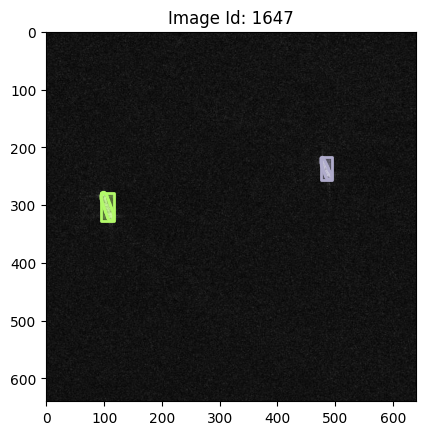

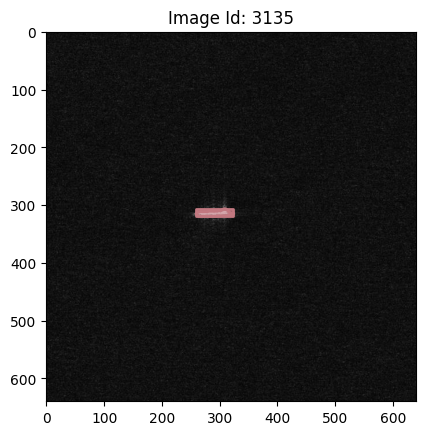

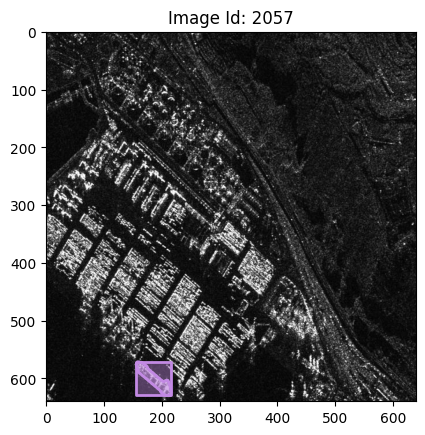

In [5]:
# Display 3 randomly selected images throughout the validation dataset with their annotations.
for i in range(3):
    train_data._random_image()
    plt.show()

## Section 4 - Faster R-CNN

This section begins the analysis of different layer additions and modifications to the Faster R-CNN model.  Each section contains the following sub-sections for reference:

1. Data Preparation
2. Model Construction
3. Training
4. Testing & Analysis

### Section 4.1 - Baseline FRCNN

This section is to establish the baseline performance of an unmodified FRCNN model on our dataset.

#### Section 4.1.1 - Data Preparation

In [6]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True, collate_fn=train_data._packager, num_workers=20)

In [7]:
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "valid")
validation_data = SeaSarFRCNN(validation_images, validation_annotations, transform=tester_transforms)
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=True, collate_fn=validation_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


#### Section 4.1.2 - Model Setup

In [8]:
# Build the baseline model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
input_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn.parameters(), lr=1e-6)
sgd = torch.optim.SGD(frcnn.parameters(), lr=1e-5)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### Section 4.1.3 - Baseline Training & Validation

When running training, be advised that you may need to close other programs, completely kill your Jupyter Kernel, or restart VSCode.  FRCNN and Pytorch consume significant amounts of memory per run and remain allocated in the background on your GPU.  After enough times running train/validation cells, the program will fail saying CUDA is out of memory.  This is when you must either manually kill background programs from the terminal or restart VSCode.  Below are the instructions to determine which programs to kill.

**NOTE**: These instructions were written for Ubuntu Linux 20.04.  Your steps may differ slightly.

1. Open a terminal window
2. Assuming you have CUDA set up, enter the "*nvidia-smi*" command.  This will display all processes currently using your GPU.
3. Run *sudo fuser -v /dev/nvidia\**.  This will display another list of process also using your GPU, including the owner of said process.
    - This step is to differentiate between your processes and system processes.  
    - **DO NOT EVER KILL A SYSTEM PROCESS USING THESE STEPS. IF IT IS CAUSING PROBLEMS, RESTART YOUR COMPUTER AND THIS CAN SAFELY REFRESH ALL PROCESSES USING YOUR GPU.**
4. Identify all processes owned by you and get their PIDs.
5. Refer back to the *nvidia-smi* table on which PID is consuming the most memory.
6. Do one of the following:
    - If possible, close the process normally like a Firefox window.
    - Run *sudo kill -9 "your_PID"*.

In [9]:
# Do training and validation
worker = ModelWorkerFRCNN(optimizer=optimizer, frcnn=frcnn, quiet=False)
worker.train(train_dataloader, 10, [3736])

Batch: 2357/2358 | Batch Loss: 0.12148369103670128

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 755.1712771728635
Loss Objectness: 258.12080048327334
RPN Region Proposal Losses: 139.60653656168142
Classifier Loss: 188.09097009524703
Bounding Box Region Loss: 169.3529717827114


Batch: 2357/2358 | Batch Loss: 0.094487212598323825

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 619.0427195169032
Loss Objectness: 98.62017380574252
RPN Region Proposal Losses: 97.09380155662075
Classifier Loss: 167.0342881884426
Bounding Box Region Loss: 256.29445486166514


Batch: 2357/2358 | Batch Loss: 0.42522647976875305

############# Epoch: 2 Complete #############
Total Epoch Combined Loss: 622.29252294451
Loss Objectness: 76.60078093461925
RPN Region Proposal Losses: 83.47445643588435
Classifier Loss: 168.7660181717947
Bounding Box Region Loss: 293.45126744452864


Batch: 2357/2358 | Batch Loss: 0.126873150467872625

############# Epoch: 3 Compl

In [10]:
# Run validation
worker.validation(validation_dataloader, 10, [])

Batch: 1345/1346 | Batch Loss: 0.104113683104515085

############# Epoch: 0 Complete #############
	Total Epoch Loss: 323.2893371582031
	Loss Objectness: 27.323417218834948
	RPN Region Proposal Losses: 34.27071085804346
	Classifier Loss: 86.55179944541305
	Bounding Box Region Loss: 175.1432586852461
Batch: 1345/1346 | Batch Loss: 0.129949748516082764

############# Epoch: 1 Complete #############
	Total Epoch Loss: 323.8097229003906
	Loss Objectness: 28.125962996535236
	RPN Region Proposal Losses: 34.43462319904211
	Classifier Loss: 85.9593691714108
	Bounding Box Region Loss: 175.29005154408514
Batch: 1345/1346 | Batch Loss: 0.070456877350807194

############# Epoch: 2 Complete #############
	Total Epoch Loss: 323.21697998046875
	Loss Objectness: 27.248411389147805
	RPN Region Proposal Losses: 34.30597287648561
	Classifier Loss: 86.59220019821078
	Bounding Box Region Loss: 175.07047476805747
Batch: 1345/1346 | Batch Loss: 1.282281756401062524

############# Epoch: 3 Complete ##########

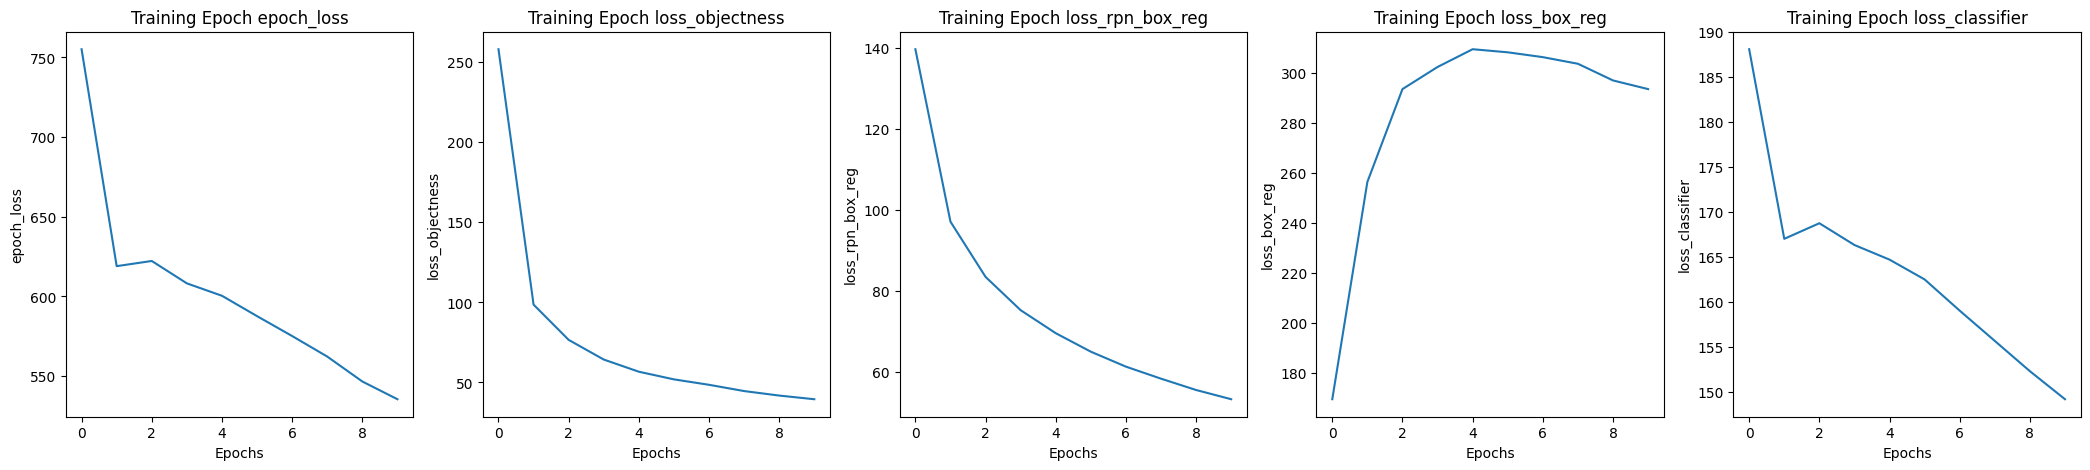

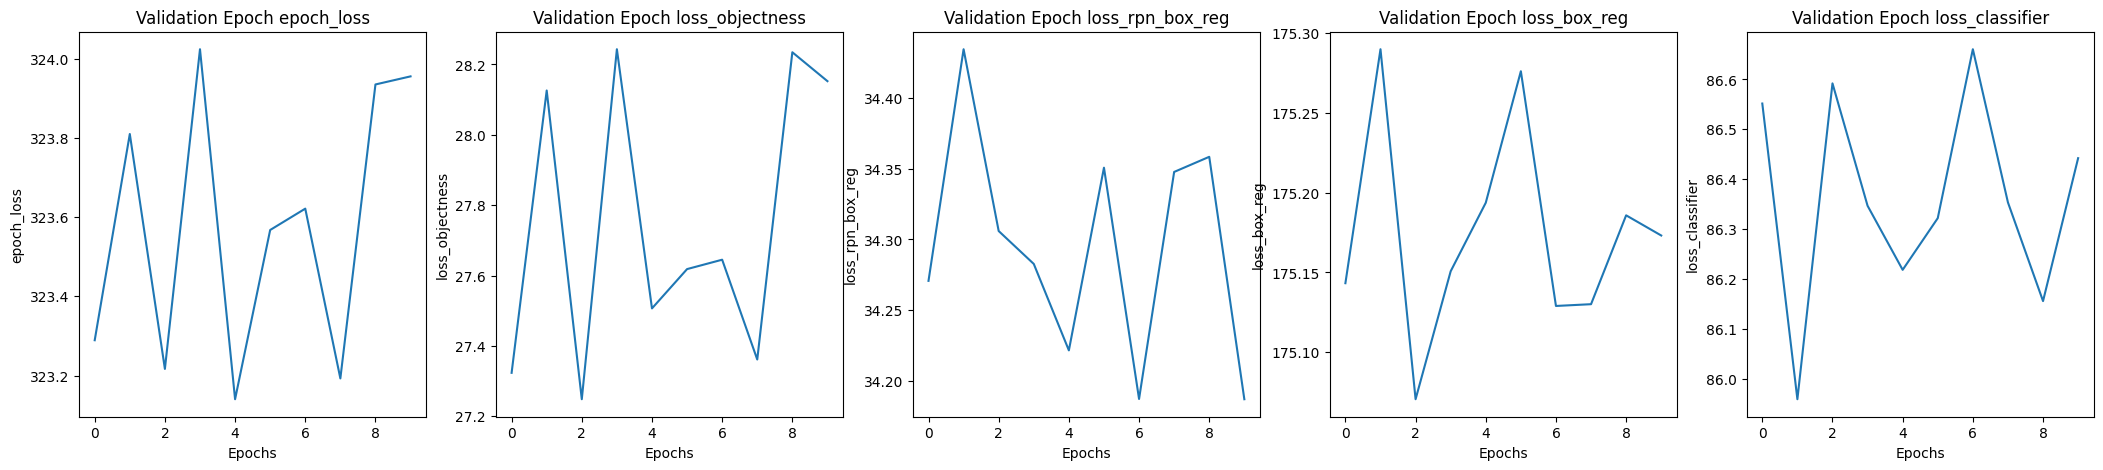

In [11]:
# Plot Baseline training and validation metrics
worker.plot_losses(True)
plt.show()
worker.plot_losses(False)
plt.show()

In [12]:
# Build the baseline model
frcnn_sgd = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
input_features_sgd = frcnn_sgd.roi_heads.box_predictor.cls_score.in_features
frcnn_sgd.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features_sgd, 2)

# Build the loss function and optimizer
sgd = torch.optim.SGD(frcnn_sgd.parameters(), lr=1e-5, momentum=0.9)
sgdWorker = ModelWorkerFRCNN(optimizer=sgd, frcnn=frcnn_sgd, quiet=False)

In [13]:
sgdWorker.train(train_dataloader, 10, [3736])

Batch: 2357/2358 | Batch Loss: 1.22408509254455572

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 1108.2772325277328
Loss Objectness: 558.1334003917873
RPN Region Proposal Losses: 174.6679364910815
Classifier Loss: 278.4678156487644
Bounding Box Region Loss: 97.0080795057147


Batch: 2357/2358 | Batch Loss: 0.116050221025943763

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 671.0844558551908
Loss Objectness: 191.07535428088158
RPN Region Proposal Losses: 141.9296008227393
Classifier Loss: 189.89623542875051
Bounding Box Region Loss: 148.18326610788063


Batch: 2357/2358 | Batch Loss: 0.23581397533416748

############# Epoch: 2 Complete #############
Total Epoch Combined Loss: 661.611904129386
Loss Objectness: 147.36913316627033
RPN Region Proposal Losses: 123.0535316974856
Classifier Loss: 197.0621513351798
Bounding Box Region Loss: 194.12708829017356


Batch: 2357/2358 | Batch Loss: 0.077269241213798526

############# Epoch: 3 Comp

In [14]:
sgdWorker.validation(validation_dataloader, 10, [])

Batch: 1345/1346 | Batch Loss: 0.071909271180629733

############# Epoch: 0 Complete #############
	Total Epoch Loss: 378.79364013671875
	Loss Objectness: 44.91509196153493
	RPN Region Proposal Losses: 47.41107561068202
	Classifier Loss: 107.6681272527203
	Bounding Box Region Loss: 178.79946109990124
Batch: 1345/1346 | Batch Loss: 0.255554497241973924

############# Epoch: 1 Complete #############
	Total Epoch Loss: 378.80340576171875
	Loss Objectness: 45.31559052124794
	RPN Region Proposal Losses: 47.36298476533557
	Classifier Loss: 107.32969821058214
	Bounding Box Region Loss: 178.7951702211285
Batch: 1345/1346 | Batch Loss: 0.128025978803634645

############# Epoch: 2 Complete #############
	Total Epoch Loss: 378.4137878417969
	Loss Objectness: 44.83132756515988
	RPN Region Proposal Losses: 47.36113714055682
	Classifier Loss: 107.47609365638345
	Bounding Box Region Loss: 178.74524325469974
Batch: 1345/1346 | Batch Loss: 0.06033550202846527

############# Epoch: 3 Complete ##########

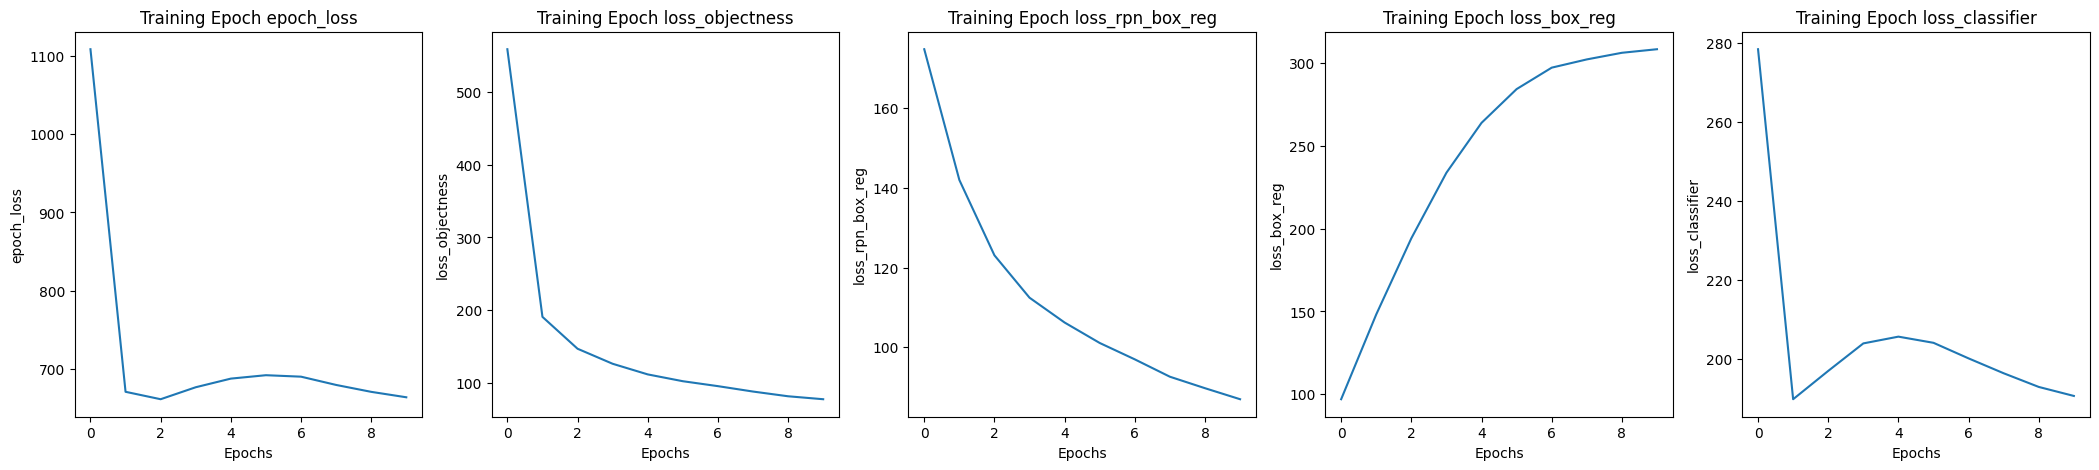

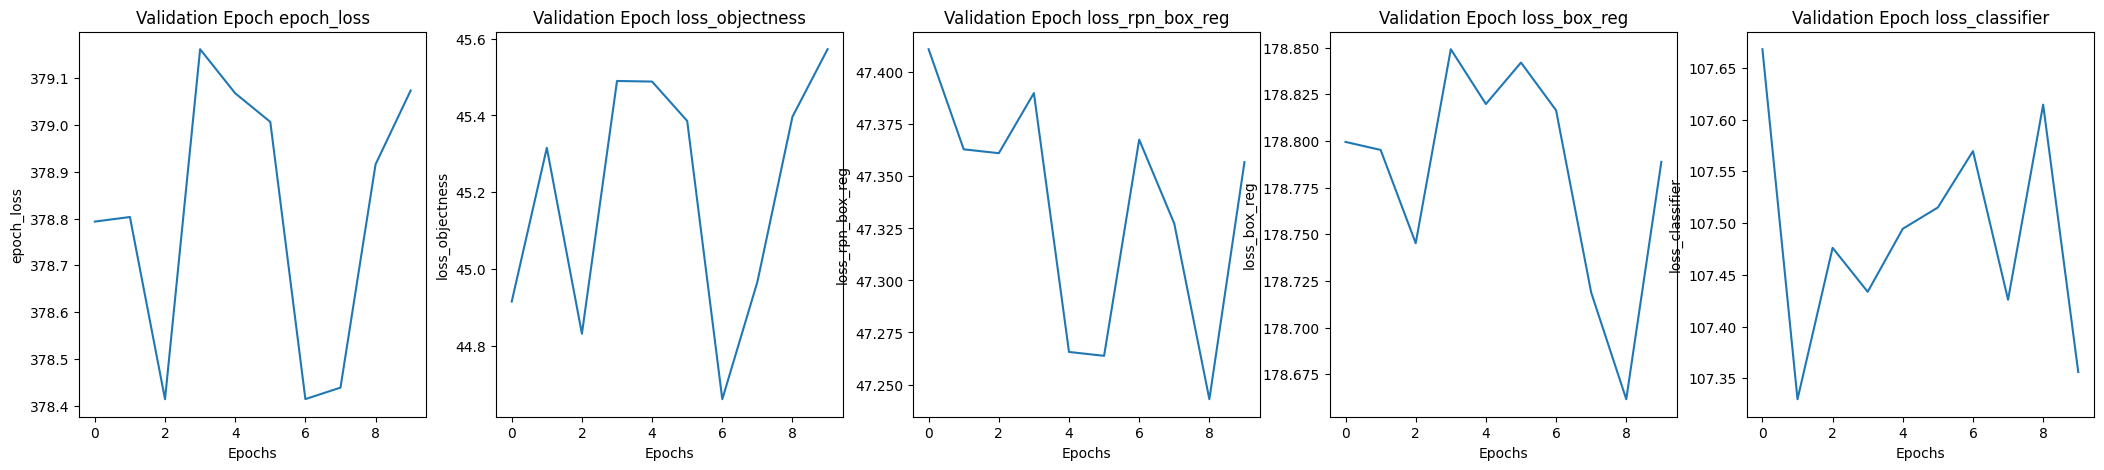

In [15]:
# Plot Baseline training and validation metrics
sgdWorker.plot_losses(True)
plt.show()
sgdWorker.plot_losses(False)
plt.show()

#### Section 4.1.4 - Baseline Testing

In [16]:
test_images = os.path.join(workspace_builder._data_path, "test")
test_annotations = os.path.join(workspace_builder._data_path, "annotations", "test_annotations.coco.json")
test_data = SeaSarFRCNN(test_images, test_annotations, transform=tester_transforms)
test_data = torchvision.datasets.wrap_dataset_for_transforms_v2(test_data, target_keys=("boxes", "labels"))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=test_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 4.2 - Adam Model Testing

In [17]:
threshold = 0.5
performance, maP = worker.model_test(test_dataloader, threshold)

In [18]:
performance = worker.get_test_metrics(performance, threshold)

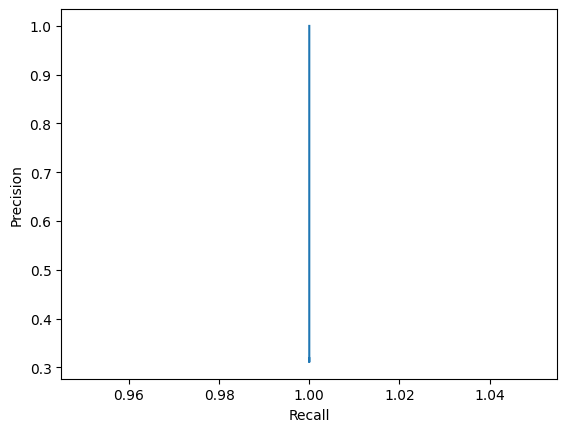

In [19]:
worker.plot_PR_curve(performance)
plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MeanAveragePrecision'>)

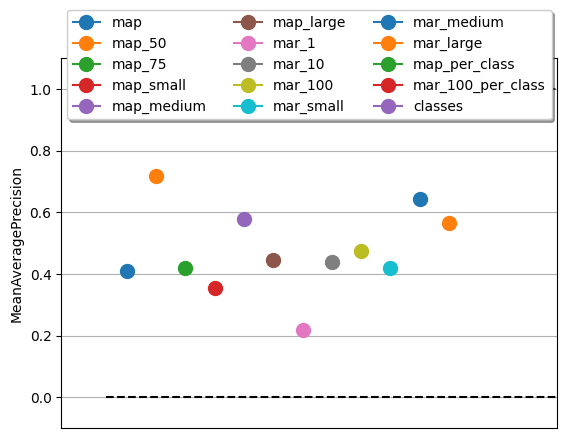

In [20]:
# Plot Mean Average Precision
maP.compute()
maP.plot()

### 4.3 - SGD Model Testing

In [21]:
# Compare with Stochastic Gradient Descent optimizer.
threshold = 0.5
performance, maP = sgdWorker.model_test(test_dataloader, threshold)

In [22]:
performance = sgdWorker.get_test_metrics(performance, threshold)

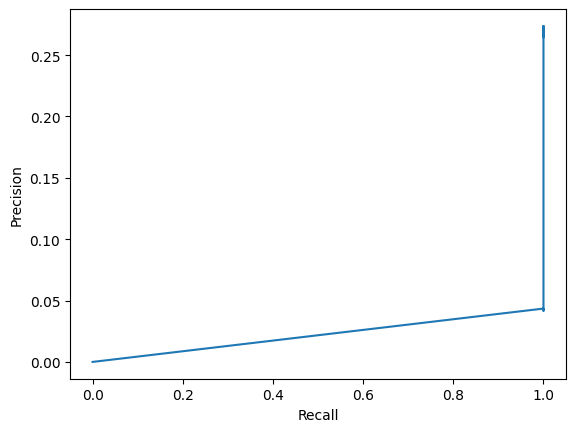

In [23]:
sgdWorker.plot_PR_curve(performance)
plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MeanAveragePrecision'>)

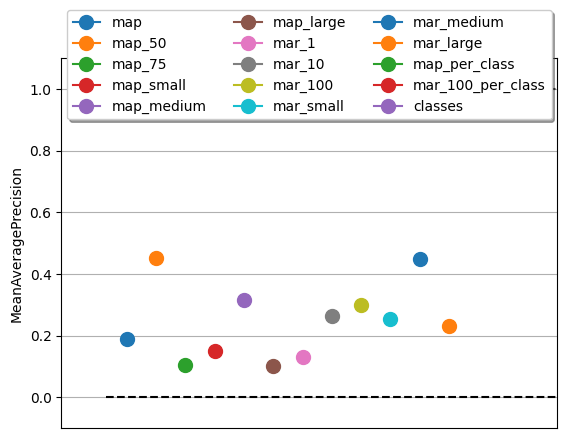

In [24]:
# Plot Mean Average Precision
maP.compute()
maP.plot()

In [25]:
# Save the Adam Variant
torch.save(frcnn.state_dict(), "/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/src/frcnn/baseline_frcnn_adam.pt")

# Save the SGD Variant
torch.save(frcnn_sgd, "/home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/src/frcnn/baseline_frcnn_sgd.pt")